In [1]:
import sys
# 1つ上の階層 (project/) を sys.path に追加
sys.path.append("..")

%load_ext autoreload
%autoreload 2

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123) # "spam"インスタンスと同じ数になるように"ham"インスタンスをランダムサンプリング
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})  # ラベルを0と1に変換

In [7]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(frac=1, random_state=123).reset_index(drop=True)  # データフレームをシャッフル
    train_end = int(len(df) * train_frac)  # 分割インデックスを計算
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df.iloc[:train_end]
    validation_df = df.iloc[train_end:validation_end]
    test_df = df.iloc[validation_end:]

    return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [8]:
train_df.to_csv("train.tsv",  index=None)
validation_df.to_csv("validation.tsv",  index=None)
test_df.to_csv("test.tsv",  index=None)


In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


In [10]:
from tiny_llm.data_loader import SpamDataset

train_dataset = SpamDataset(
    csv_file="train.tsv",
    max_length=None,
    tokenizer=tokenizer,
)

print(train_dataset.max_length)

120


In [11]:
val_dataset = SpamDataset(
    csv_file="validation.tsv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)

test_dataset = SpamDataset(
    csv_file="test.tsv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)

In [12]:
import torch
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [13]:
for input_batch, target_batch in train_loader:
    pass


print("Input batch dimensions:", input_batch.shape)
print("Target batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Target batch dimensions: torch.Size([8])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate_emb": 0.0,      
    "drop_rate_attn": 0.0,     
    "drop_rate_shortcut": 0.0, 
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [16]:
from gpt_download import download_and_load_gpt2
from tiny_llm.gpt_model import GPTModel
from tiny_llm.utils import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [17]:
from tiny_llm.utils import generate_text_simple, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size= BASE_CONFIG["context_length"],
)
print(token_ids)
print(token_ids_to_text(token_ids, tokenizer))

tensor([[6109, 3626, 6100,  345, 2651,   13,  198,  198,  464,  717, 2239,  318,
          284, 1833,  262, 6817,  286,  534,  670]])
Every effort moves you forward.

The first step is to understand the importance of your work


In [18]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size= BASE_CONFIG["context_length"],
)

print(token_ids)
print(token_ids_to_text(token_ids, tokenizer))

tensor([[ 3792,   262,  1708,  2420,   705,  2777,   321, 30960, 23998,   351,
           705,  8505,     6,   393,   705,  3919, 10354,   705,  1639,   389,
           257,  8464,   345,   423,   587, 20905,  6163,   284,  3328,   720,
         12825,  5003,   393,   257,   720, 11024,  5764,  2637,   198,   198,
           464,  1708,  2420,   705,  2777,   321, 30960, 23998,   351,   705,
          8505,     6,   393,   705,  3919, 10354,   705,  1639,   389,   257,
          8464]])
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [19]:
for param in model.parameters():
    param.requires_grad = False # モデルを凍結する

In [20]:
torch.manual_seed(123)

# 分類層を追加する
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [21]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True  # 最後のトランスフォーマーブロックのパラメータのみ学習可能にする

for param in model.final_norm.parameters():
    param.requires_grad = True  # 最後の正規化層のパラメータを学習可能にする

In [22]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [23]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [24]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [25]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [26]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [27]:
from tiny_llm.utils import calc_accuracy_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")
print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Running on mps device.
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [28]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    outputs = model(input_batch)
    logits = outputs[:, -1, :]  # 最後のトークンの出力を取得
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [29]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss =0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [30]:
with torch.no_grad(): # まだモデルを訓練していないため、効率を考慮して勾配の追跡を無効にする
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 6.288
Validation loss: 6.805
Test loss: 5.838


In [33]:
import time
from tiny_llm.classifier import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=0.1,
)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5    
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss: 5.362, Val loss: 6.145
Ep 1 (Step 000050): Train loss: 0.420, Val loss: 0.542
Ep 1 (Step 000100): Train loss: 0.330, Val loss: 0.445
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 2 (Step 000150): Train loss: 0.469, Val loss: 0.375
Ep 2 (Step 000200): Train loss: 0.178, Val loss: 0.277
Ep 2 (Step 000250): Train loss: 0.162, Val loss: 0.217
Training accuracy: 95.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss: 0.117, Val loss: 0.276
Ep 3 (Step 000350): Train loss: 0.061, Val loss: 0.170
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss: 0.016, Val loss: 0.205
Ep 4 (Step 000450): Train loss: 0.097, Val loss: 0.233
Ep 4 (Step 000500): Train loss: 0.113, Val loss: 0.171
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss: 0.116, Val loss: 0.194
Ep 5 (Step 000600): Train loss: 0.032, Val loss: 0.185
Training accuracy: 100.00% | Validation accuracy: 97.50%
Tra

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny() # すでに見たサンプル用の２つ目のx軸を作成
    ax2.plot(examples_seen, train_values, alpha=0) # 目盛を揃えるための不可視のプロット
    ax2.set_xlabel("Examples seen")

    fig.tight_layout() # レイアウトを調整してスペースを確保
    plt.savefig(f"{label}_plot.png")
    plt.show()    

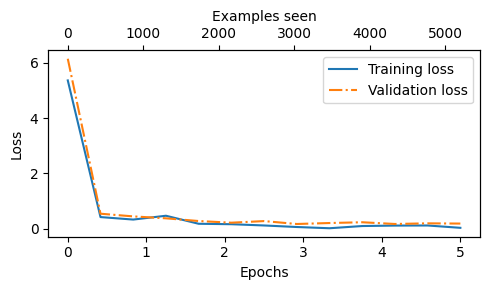

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

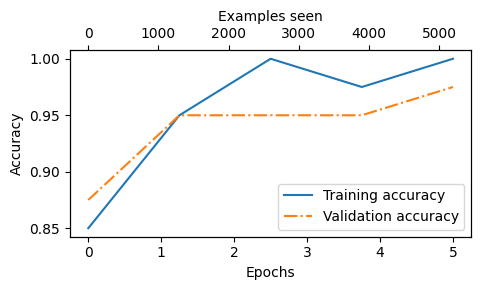

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


In [42]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.27%
Validation accuracy: 97.32%
Test accuracy: 97.00%


In [43]:
from tiny_llm.classifier import classify_review

text_1 = "Your are a winner you have been specially selected to recieve $1000 cash or a $2000 award." 
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [ ]:
text_2 = "Hey, just wanted to check if we're still on for dinner tonight? Let me know!" 
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [49]:
torch.save(model.state_dict(), "review_classifier.pth")

In [50]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>